In [128]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy

In [129]:
Directory = os.getcwd()
Directory_path = Directory + '/data/input'
files = os.listdir(Directory_path)
plot_Directory = Directory + '/plots'

In [130]:
#!pip install networkx==2.5.0 python-louvain

In [131]:
#nx.__version__

In [132]:
plt.rcParams['font.size'] = '13'

## Extracting for all cells: 

## Read data :

In [133]:
PATIENT_ID = '1X1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
### Threshold is the edge threshold that we will consider
SHOW_PLOTS =False   
HIGH_VOLUME = True
MIN_ELEMENTS_PER_CLUSTER = 100
### The border values will extract only the border degined in the edge_neighberhood
BORDER = True

### Nodes 

In [134]:
nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')
                    
### Setting cell_id as index

nodes.set_index('cell_id', inplace=True)
#nodes['phenotype'] = nodes['phenotype'].apply(lambda x: get_phenotype(x))

In [135]:
nodes.phenotype.value_counts()

tumor          154612
stroma          61914
T               14117
macrophages      2984
MISSING          2715
B                 882
DP1               172
dendtritic        162
NK                 75
DP2                 4
Name: phenotype, dtype: int64

## Defining nodes_stats
nodes_stats is a Dataframe that will englobe all the information about the slide in one row. it will be used to study feature importance in predicting immunotherapy response.

In [136]:
nodes_stats = pd.DataFrame(nodes.phenotype.value_counts()/len(nodes)).reset_index()
nodes_stats = pd.pivot_table(nodes_stats,columns='index').reset_index()
nodes_stats.columns.name = None 
nodes_stats = nodes_stats.rename(columns={'index':'name'})
nodes_stats['name'] = PATIENT_ID

In [137]:
nodes_stats

,name,B,DP1,DP2,MISSING,NK,T,dendtritic,macrophages,stroma,tumor
0,1X1,0.003712,0.000724,0.000017,0.011425,0.000316,0.059406,0.000682,0.012557,0.26054,0.650623


In [138]:
len(nodes)

237637

# Edges : Edges of the cell graph
In this part we will only consider the border 

In [139]:
### Importing edges with distance threshold 100

edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')

#### Fixing distance threshold and removing tumor border

####edges = graph_wrangling(edges,THRESHOLD, only_border = False)

In [140]:
cells_in_edges = get_cells_from_edges(edges)

In [141]:
edges.head(2)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,threshold,is_border
0,16.491513,24919,24973,tumor,tumor,macrophages,tumor,20.310625,False
1,19.925110,13934,13936,tumor,tumor,stroma,tumor,20.595000,False


In [142]:
N_EDGES = len(edges)
nodes_stats['nbr_edges'] = N_EDGES

# Counting edges for the whole graph

In [143]:
edge_phenotype_count = edges.groupby(['phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

In [144]:
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

In [145]:
edge_phenotype_count = edge_phenotype_count[['edge_count','edge_type']]
edge_count = copy.deepcopy(edge_phenotype_count)
edge_count['edge_count'] = edge_phenotype_count['edge_count'].apply(lambda x: x/N_EDGES)
edge_phenotype_count_pivotted = pd.pivot_table(edge_count, values='edge_count',columns=['edge_type'], aggfunc=np.sum)
edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.drop(['index'], axis=1)

In [146]:
edge_phenotype_count_pivotted

,B-B,DP1-B,DP1-DP1,MISSING-B,MISSING-DP1,MISSING-DP2,MISSING-MISSING,T-B,T-DP1,T-DP2,...,stroma-stroma,tumor-B,tumor-DP1,tumor-DP2,tumor-MISSING,tumor-T,tumor-dendtritic,tumor-macrophages,tumor-stroma,tumor-tumor
0,0.000487,8.014734e-07,0.000027,0.000045,0.000011,8.014734e-07,0.000877,0.001646,0.00003,0.000002,...,0.117115,0.001798,0.000894,0.000012,0.012146,0.033245,0.000095,0.01128,0.195731,0.580692


In [147]:
nodes_stats = nodes_stats.join(edge_phenotype_count_pivotted)

In [148]:
del edge_phenotype_count_pivotted

# AUC for the whole graph:


In [149]:
Min_distance = np.min(edges.distance)
Max_distance = np.max(edges.distance)

In [150]:
distribution = G_cross_function(edges,Min_distance,Max_distance,1000)

In [151]:
nodes_stats['AUC_total_graph'] = compute_AUC(distribution)

# Number of infilterated TILs

We call a TIL cell infiltrated if the cell's tissue category is a tumor and the phenotype is T,B or NK. In this section we will try to distinguish between the ratio of infiltration on the border and out of border.

The variables that we will extract are normalised.


In [152]:
TILs = ['T','B','NK']
df_in_border_pivotted = get_infiltrated_tils(nodes, TILs, on_border=True)
df_in_border_pivotted = df_in_border_pivotted.rename(columns = {'B':'B_in','NK':'NK_in','T':'T_in'})
df_out_border_pivotted = get_infiltrated_tils(nodes, TILs, on_border=False)
df_out_border_pivotted = df_out_border_pivotted.rename(columns = {'B':'B_out','NK':'NK_out','T':'T_out'})


In [153]:
nodes_stats = nodes_stats.join(df_out_border_pivotted)

In [154]:
nodes_stats = nodes_stats.join(df_in_border_pivotted)

In [155]:
del df_out_border_pivotted
del df_in_border_pivotted

## Mean degree per phenotype

In [156]:
cell_degree = pd.read_csv(OUTPUT_PATH+'cell_degree.csv')

In [157]:
cell_degree.head(2)

,cell_id,stroma_degree,missing_degree,tumor_degree,total_degree,stroma_pheno_degree,macrophages_degree,T_degree,MISSING_degree,tumor_pheno_degree,B_degree,DP1_degree,DP2_degree,dendtritic_degree
0,8,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,4.0,0.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
average_degree = pd.DataFrame(cell_degree.mean()).reset_index()
average_degree = pd.pivot_table(average_degree,columns='index').reset_index()
average_degree.columns.name =None 
average_degree = average_degree.drop(['index','cell_id'], axis=1)
#nodes_stats = nodes_stats.rename(columns={'index':'name'})

In [159]:
nodes_stats = nodes_stats.join(average_degree)

### Degree per tissue and phenotype

In [160]:
nodes = nodes.merge(cell_degree, on='cell_id',how='left')

In [161]:
whole_cell_graph =nx.from_pandas_edgelist(edges, 'cell_id_1', 'cell_id_2', edge_attr=None, create_using= nx.Graph())
nodes_stats['whole_graph_sparsity'] = nx.density(whole_cell_graph)
nodes_stats['whole_graph_transitivity'] = nx.transitivity(whole_cell_graph)

In [162]:
del whole_cell_graph

# Building the graph on Margin border
Here the graph will be build on the neighberhood of the border, not all the cells will be included. The border Variable filter out the edges that are not in the border.

In [163]:
if BORDER:
    edges = edges[edges.is_border== True]
    nodes = nodes[nodes.on_border == True]
    
    
cell_graph =nx.from_pandas_edgelist(edges, 'cell_id_1', 'cell_id_2', edge_attr=None, create_using= nx.Graph())
describe_graph(cell_graph)

Name: 
Type: Graph
Number of nodes: 76901
Number of edges: 319186
Average degree:   8.3012
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0001
Global clustering coefficient aka Transitivity: 0.5317


In [164]:
nodes_stats['border_graph_sparsity'] = nx.density(cell_graph)
nodes_stats['border_graph_transitivity'] = nx.transitivity(cell_graph)

### Degree distribution

In [165]:
plot_degree_distribution(cell_graph,savefig = True, figname = 'Degreed_itribution_bipartite.png',PLOT_PATH=PLOT_PATH,no_show = SHOW_PLOTS );
plt.close()

### Adding nodes attributes

In [166]:
nx.set_node_attributes(cell_graph, nodes['cell_x_position'].to_dict(), 'x_position' )
nx.set_node_attributes(cell_graph, nodes['cell_y_position'].to_dict(), 'y_position' )
nx.set_node_attributes(cell_graph, nodes['tissue_category'].to_dict(), 'tissue_category' )
nx.set_node_attributes(cell_graph, nodes['phenotype'].to_dict(), 'phenotype' )
nx.set_node_attributes(cell_graph, nodes['on_border'].to_dict(), 'border')

# Connected components

### Filtering components

In [167]:
components = list(nx.connected_components(cell_graph))
nodes_stats['n_initial_components'] =  len(components)
print('The cell graph contains', len(components), 'connected components')
largest_comp = max(components, key=len)
percentage_lcc = len(largest_comp)/cell_graph.number_of_nodes() * 100
#nodes_stats['size_largest_component'] =  len(components)

print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')
components = filtering_components(components, MIN_ELEMENTS_PER_CLUSTER)
components = sorted(components, key=len, reverse=False)
print(len(components),' components have at least ',MIN_ELEMENTS_PER_CLUSTER,' nodes')
nodes_stats['n_final_components'] =  len(components)


The cell graph contains 357 connected components
The largest component has 8499 nodes accounting for 11.05 % of the nodes
89  components have at least  100  nodes


### Clustering coefficient

Compute the clustering coefficient for nodes.
For unweighted graphs, the clustering of a node $u$ is the fraction of possible triangles through that node that exist,
$$
c_{u}=\frac{2 T(u)}{\operatorname{deg}(u)(\operatorname{deg}(u)-1)}
$$
where $T(u)$ is the number of triangles through node $u$ and $\operatorname{deg}(u)$ is the degree of $u$.

In [168]:
#nodes_of_interest = get_subnodes(cell_graph,'phenotype',['T','B','NK','macrophages', 'dendtritic','tumor'])
clustering_coef = nx.clustering(cell_graph)

In [169]:
clustering_df =  pd.DataFrame(clustering_coef.items(),columns=['cell_id','clustering_coef'])
nodes = nodes.merge(clustering_df, on ='cell_id', how='left')

In [170]:
clustering_df_grouped = nodes.groupby(['phenotype'])['clustering_coef'].agg(['mean','median','var'])

In [171]:
nodes_stats['median_clustering_coefficient'] = np.median(clustering_df.clustering_coef.values)
nodes_stats['var_clustering_coefficient'] = np.median(clustering_df.clustering_coef.values)
nodes_stats['mean_clustering_coefficient'] = np.median(clustering_df.clustering_coef.values)


In [172]:
del clustering_df

We see a positive density for negative values which is weird since the dataframe does not contain any negative value for BC : Dispolt problem from seaborn

### Describe graph

In [173]:
components = list(nx.connected_components(cell_graph))
subgraphs = [cell_graph.subgraph(c).copy() for c in components]

In [174]:
#for index, component in enumerate(subgraphs):
#    print('Component number :', index)
#    print(nx.info(component))

In [175]:
map_to_component = {}

for index, component in enumerate(components) :
    
    elements_component = list(component)
    for element in elements_component:
        
        map_to_component[element] = index    

In [176]:
nodes['component'] = nodes.reset_index()['cell_id'].apply(lambda x: map_to_component[x]if x in map_to_component.keys() else '')

In [177]:
edges['component'] = edges.cell_id_1.apply(lambda x: map_to_component[x] if x in map_to_component.keys() else '')

In [178]:
size_df = nodes.groupby('component').agg('count').sort_values('cell_id')['cell_id'].reset_index().rename(columns = {'cell_id':'size'})

In [179]:
nodes = nodes.merge(size_df,on='component',how='left')
N = len(edges)
r = int((N/1000)/2000)+1 
q = [int(c) for c in np.linspace(0, N, r+2)]
edges_merged = pd.DataFrame({})
print('Dividing to '+ str(len(q)) + ' parts, done')
for index in range(len(q))[1:]:
    lower_bound = q[index-1]
    upper_bound = q[index]
    edges_slice = edges[lower_bound:upper_bound].copy()
    edges_slice = edges_slice.merge(size_df,on='component',how='left')
    edges_merged = pd.concat([edges_merged,edges_slice])
    
edges = edges_merged 
del edges_merged

Dividing to 3 parts, done


## Filtering : Considering only components with number of nodes greater than 100

In [180]:
nodes = nodes[nodes['size']> MIN_ELEMENTS_PER_CLUSTER]
edges = edges[edges['size']> MIN_ELEMENTS_PER_CLUSTER]

## G-cross function per component

In [181]:
AUC_per_component={}
components_in_graph = edges.component.unique()
for component in components_in_graph :
    
    edge_component_df = edges[edges.component == component].copy()
    distribution =  G_cross_function(edge_component_df,min_radius=10, max_radius=20,radius_numbers=20,TILs=['T','B'])
    area = compute_AUC(distribution)
    AUC_per_component[component] = area
    
AUC_per_component = pd.melt(pd.DataFrame(AUC_per_component, index = [0])) 
AUC_per_component = AUC_per_component.rename(columns = {'variable':'component','value':'AUC_area'})    
     
    

In [182]:
edges = edges.merge(AUC_per_component,on = 'component', how ='left')
nodes = nodes.merge(AUC_per_component,on = 'component', how ='left')

In [183]:
edges.to_csv(OUTPUT_PATH + 'edges_with_component.csv', index = False)

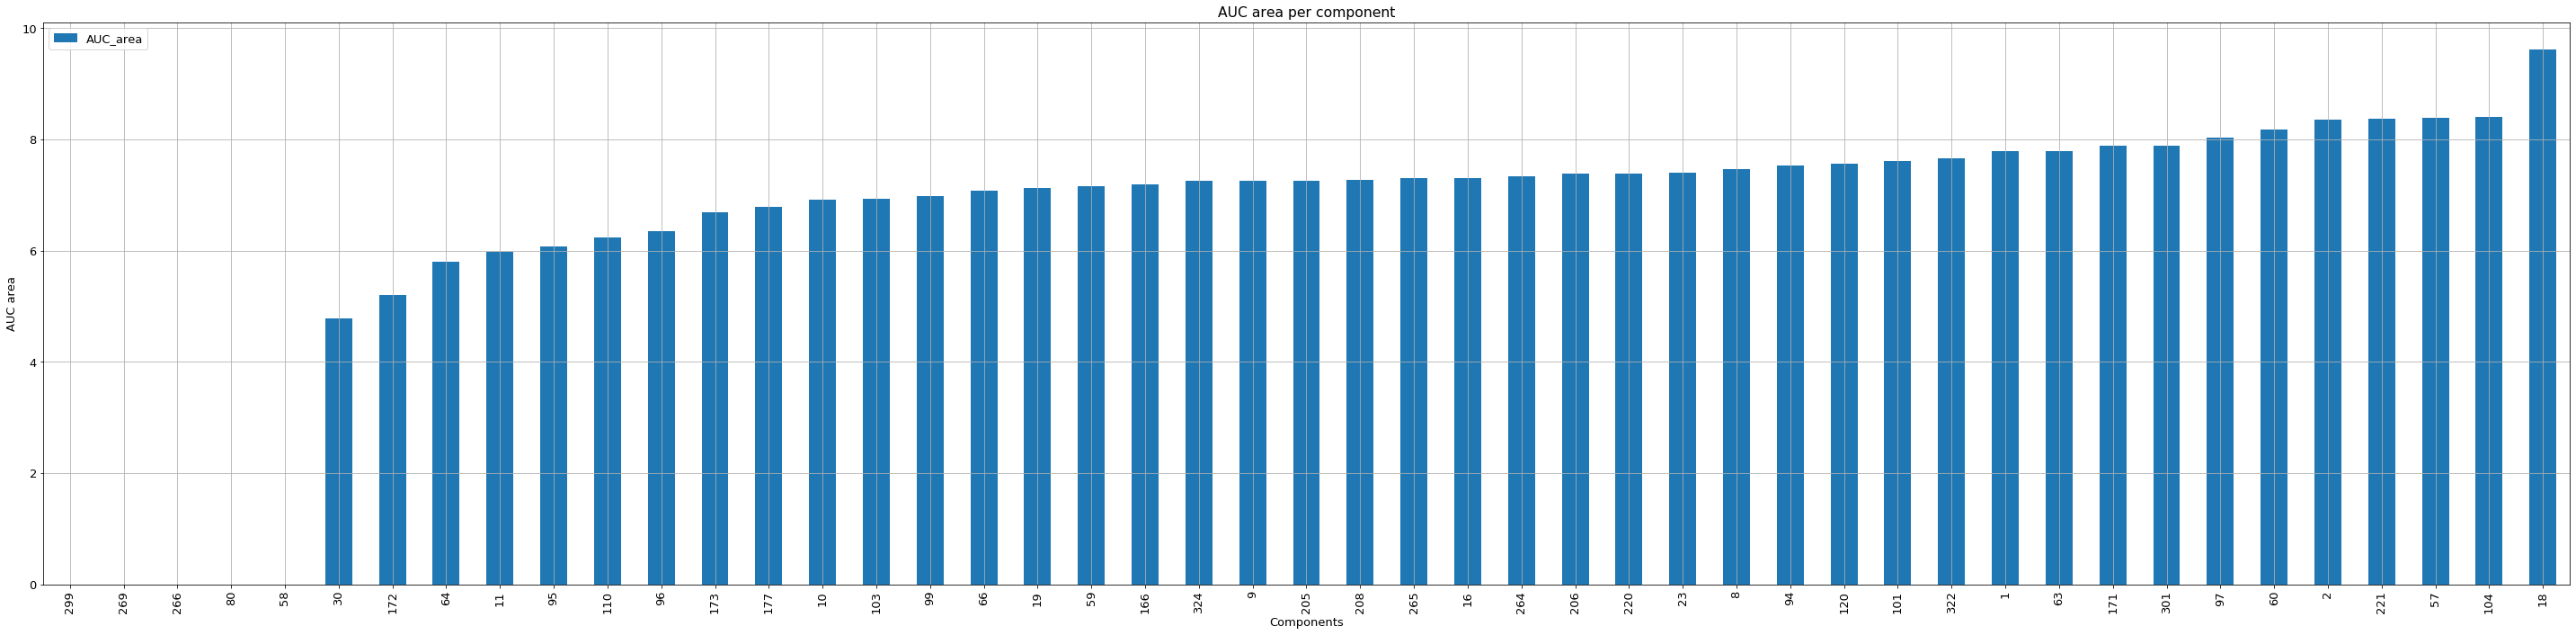

In [184]:
fig = AUC_per_component.sort_values(['AUC_area']).plot.bar(x='component',y='AUC_area',rot=90,figsize =(40,10))
plt.xlabel('Components')
plt.ylabel('AUC area')
plt.grid()
plt.title('AUC area per component')
plt.tight_layout()

plt.savefig(PLOT_PATH + 'AUC_area.png')


In [185]:
del AUC_per_component

## Counting edges per component

In [186]:
edge_phenotype_count = edges.groupby(['component','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

In [187]:
number_per_component = edges.groupby(['component']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_component'})

In [188]:
edge_phenotype_count = edge_phenotype_count.merge(number_per_component,on='component',how='left')

In [189]:
edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_component']

In [190]:
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

In [191]:
edge_phenotype_count = edge_phenotype_count[['component','edge_count_ratio','edge_type']]

In [192]:
edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['component'],
                    columns=['edge_type'], aggfunc=np.sum)

edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

In [193]:
edge_phenotype_count_pivotted.head()

,component,B-B,DP1-B,DP1-DP1,MISSING-B,MISSING-DP2,MISSING-MISSING,T-B,T-DP1,T-DP2,...,stroma-stroma,tumor-B,tumor-DP1,tumor-DP2,tumor-MISSING,tumor-T,tumor-dendtritic,tumor-macrophages,tumor-stroma,tumor-tumor
0,1,0.003303,0.0,0.0,0.000000,0.0,0.000000,0.010568,0.0,0.000000,...,0.091149,0.011889,0.0,0.000000,0.000000,0.095773,0.000000,0.017173,0.235799,0.453104
1,2,0.001934,0.0,0.0,0.000000,0.0,0.000000,0.010638,0.0,0.000000,...,0.062863,0.044487,0.0,0.000000,0.000000,0.135397,0.000000,0.014507,0.220503,0.435203
2,8,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.119163,0.000000,0.0,0.000000,0.006441,0.017713,0.000000,0.019324,0.178744,0.644122
3,9,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.069368,0.000000,0.0,0.000000,0.005495,0.019231,0.000000,0.020604,0.287775,0.565247
4,10,0.000414,0.0,0.0,0.000104,0.0,0.000207,0.001968,0.0,0.000104,...,0.056655,0.005075,0.0,0.000104,0.004247,0.091248,0.000414,0.023822,0.205179,0.499637


In [194]:
columns_of_interest = edge_phenotype_count_pivotted.columns

In [195]:
columns = edge_phenotype_count_pivotted.columns
for interest in columns_of_interest:
    if not(interest in columns):
        edge_phenotype_count_pivotted[interest] = 0
            

In [196]:
edges_of_interest = edge_phenotype_count_pivotted[columns_of_interest]

In [197]:
edges_of_interest.head()

,component,B-B,DP1-B,DP1-DP1,MISSING-B,MISSING-DP2,MISSING-MISSING,T-B,T-DP1,T-DP2,...,stroma-stroma,tumor-B,tumor-DP1,tumor-DP2,tumor-MISSING,tumor-T,tumor-dendtritic,tumor-macrophages,tumor-stroma,tumor-tumor
0,1,0.003303,0.0,0.0,0.000000,0.0,0.000000,0.010568,0.0,0.000000,...,0.091149,0.011889,0.0,0.000000,0.000000,0.095773,0.000000,0.017173,0.235799,0.453104
1,2,0.001934,0.0,0.0,0.000000,0.0,0.000000,0.010638,0.0,0.000000,...,0.062863,0.044487,0.0,0.000000,0.000000,0.135397,0.000000,0.014507,0.220503,0.435203
2,8,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.119163,0.000000,0.0,0.000000,0.006441,0.017713,0.000000,0.019324,0.178744,0.644122
3,9,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.069368,0.000000,0.0,0.000000,0.005495,0.019231,0.000000,0.020604,0.287775,0.565247
4,10,0.000414,0.0,0.0,0.000104,0.0,0.000207,0.001968,0.0,0.000104,...,0.056655,0.005075,0.0,0.000104,0.004247,0.091248,0.000414,0.023822,0.205179,0.499637


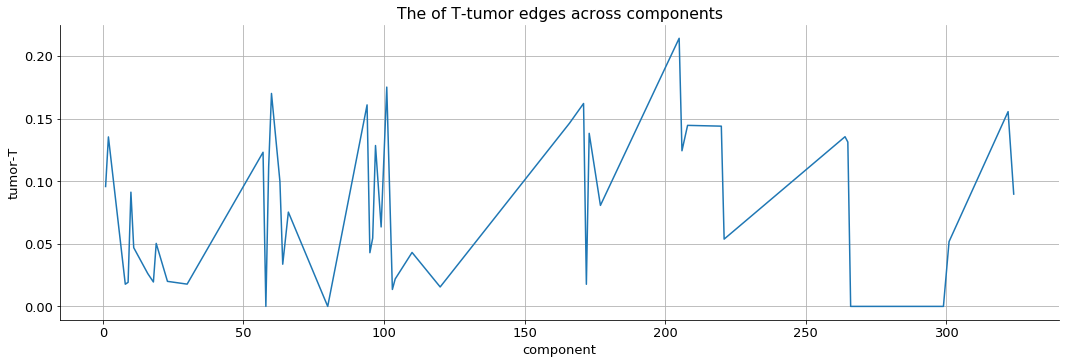

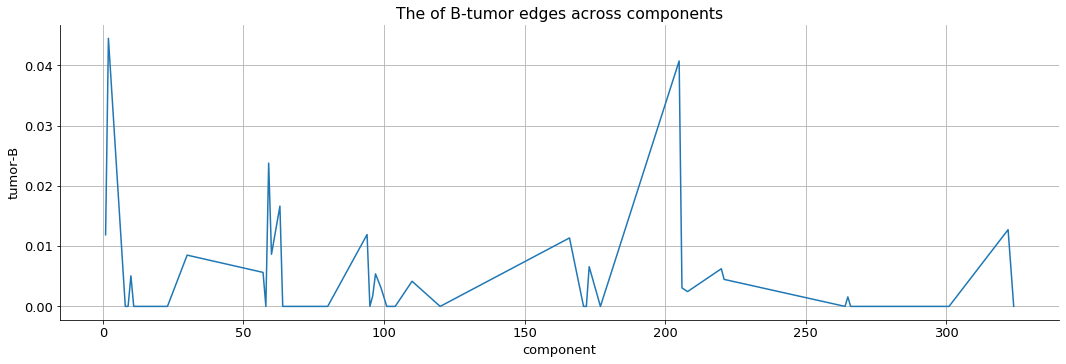

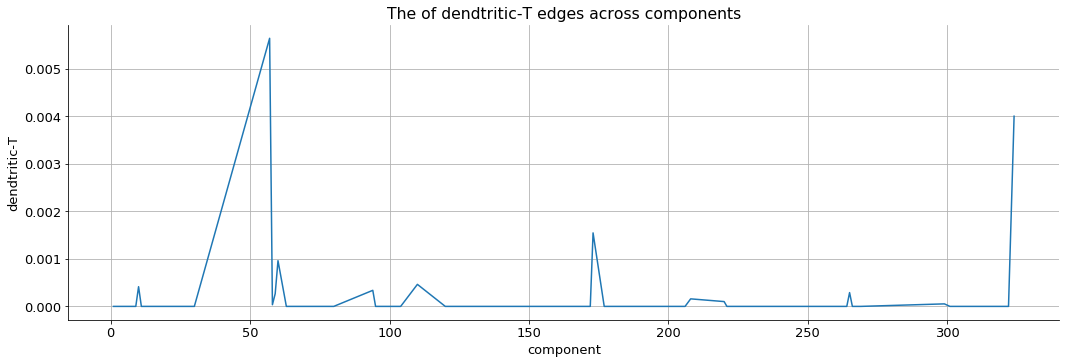

In [198]:
plot_relplot(edges_of_interest,'component','tumor-T',PLOT_PATH,'Reds','The of T-tumor edges across components',True)
plot_relplot(edges_of_interest,'component','tumor-B',PLOT_PATH,'Reds','The of B-tumor edges across components',True)
plot_relplot(edges_of_interest,'component','dendtritic-T',PLOT_PATH,'Reds','The of dendtritic-T edges across components',True)
#plot_relplot(edges_of_interest,'component','dendtritic-Tumor',PLOT_PATH,'Reds','The of NK-tumor edges across components',True)

We can merge the total information about edge counting but here we will restric only to tumor vs (T, B, NK,..)

In [199]:
nodes = nodes.merge(edges_of_interest, on='component',how='left')

In [200]:
del edges_of_interest
del edge_phenotype_count_pivotted
del edge_phenotype_count

In [201]:
nodes = nodes.fillna(0)

In [202]:
nodes.component.unique()

array([ 10, 177,  18,  16,  23,   8, 172, 269, 266,   9,  19, 173, 166,
       264,   1, 171, 265,  30,   2,  11,  80,  57,  59, 205, 206, 301,
        66,  60,  63,  64, 208, 299,  58, 110, 220, 120,  97,  94, 324,
       322,  96, 103, 101, 221,  95,  99, 104])

## Plotting nodes

### Differentiating components

In [203]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = nodes , x='cell_x_position', y= 'cell_y_position', hue = 'tissue_category').get_figure().savefig(PLOT_PATH+'scatter_per_tissue_type.png');
plt.close()

In [204]:
#vis_nodes = nodes

fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = nodes , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype').get_figure().savefig(PLOT_PATH+'scatter_per_phenotype.png');
plt.close()

### Differentiating Tissue

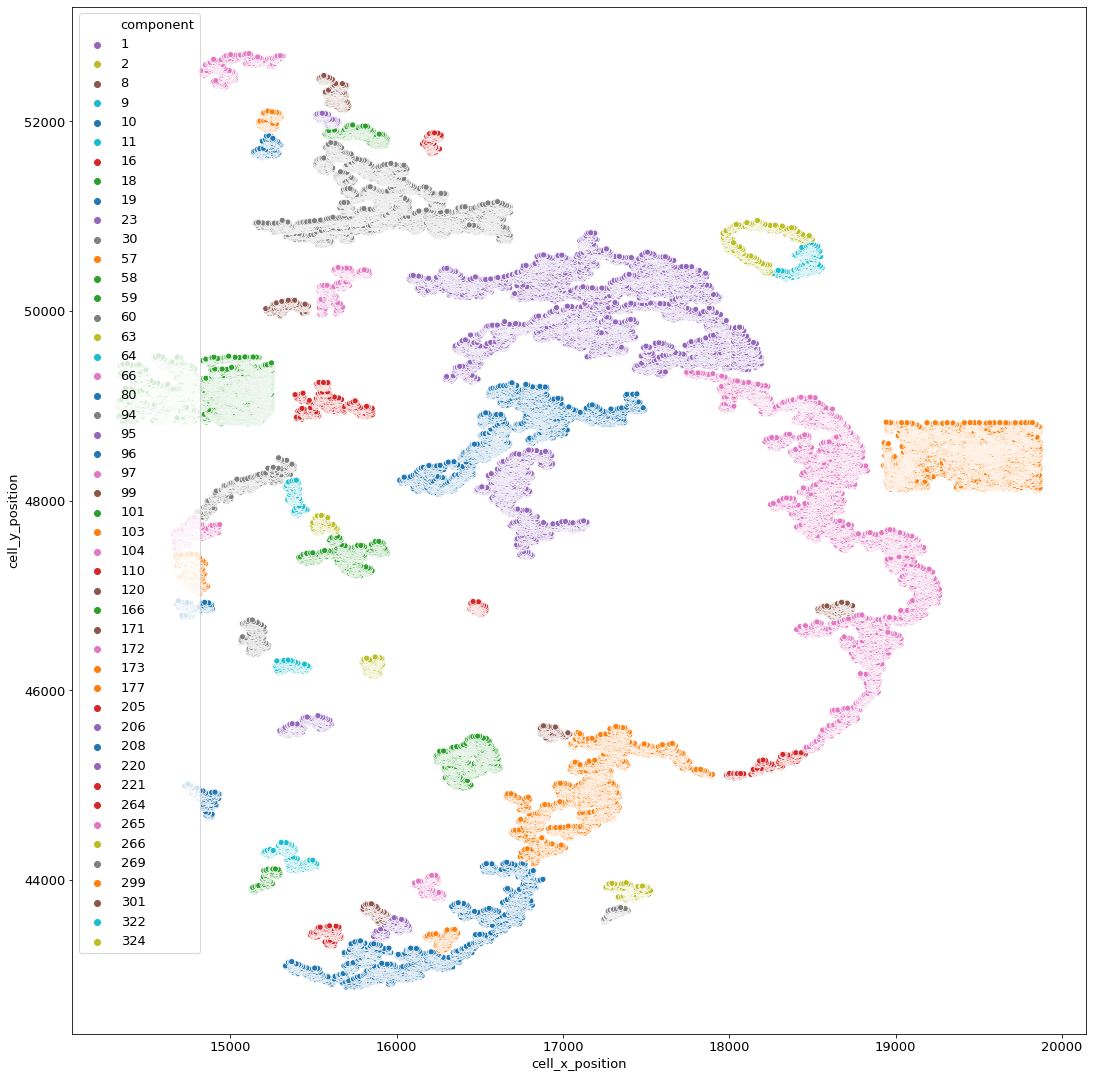

In [205]:
vis_nodes = nodes 
fig, ax = plt.subplots(figsize = (15,15))
unique = vis_nodes["component"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
#color = random.shuffle(sns.color_palette())
plt.tight_layout()

sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component', palette =palette).get_figure().savefig(PLOT_PATH+'scatter_only_components.png')
#plt.close()



In [206]:
#vis_nodes = nodes[(nodes.phenotype != 'stroma')  & (nodes.phenotype != 'MISSING') ]
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype',
               # cmap =sns.color_palette("tab10")).get_figure().savefig(PLOT_PATH+'scatter_phenotype_no_stroma_no_tumor.png')

## plotting component graphs

### Structural plotting

In [207]:
MIN_NUMBER_PER__COMPONENT = 60
COMPONENT_NUM = 92
REMOVE_STROMA = False
BIPARTITE = False
SPATIAL = True
SAVE_FIG = True
FIG_NAME ='component_102_without_stroma_structural_plot'

In [208]:
#plot_component(cell_graph,PLOT_PATH,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#            remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#              savefig=SAVE_FIG, figname=FIG_NAME)

## Density analysis per component

In [209]:
phenotype_component_grouped = pd.DataFrame(nodes.groupby(['component','phenotype']).agg('count')['cell_id']).reset_index()

In [210]:
phenotype_component_grouped = phenotype_component_grouped.merge(size_df, on='component',how='left')

In [211]:
phenotype_component_grouped['pheno_ratio'] = phenotype_component_grouped['cell_id']/phenotype_component_grouped['size']

In [212]:
phenotype_component_pivotted = pd.pivot_table(phenotype_component_grouped, values='pheno_ratio', index=['component'],
                    columns=['phenotype'], aggfunc=np.sum)

phenotype_component_pivotted.columns.name = None

phenotype_component_pivotted = phenotype_component_pivotted.fillna(0).sort_values(['T']).reset_index()

In [213]:
phenotype_component_pivotted.head(5)

,component,B,DP1,DP2,MISSING,T,dendtritic,macrophages,stroma,tumor
0,269,0.000000,0.0,0.000000,0.000000,0.000000,0.008264,0.057851,0.925620,0.008264
1,58,0.000316,0.0,0.000158,0.005687,0.003633,0.009479,0.006161,0.974566,0.000000
2,299,0.000169,0.0,0.000000,0.010649,0.004902,0.006423,0.007099,0.970757,0.000000
3,18,0.000000,0.0,0.000000,0.016529,0.008264,0.000000,0.016529,0.223140,0.735537
4,8,0.000000,0.0,0.000000,0.000000,0.008547,0.000000,0.025641,0.307692,0.658120


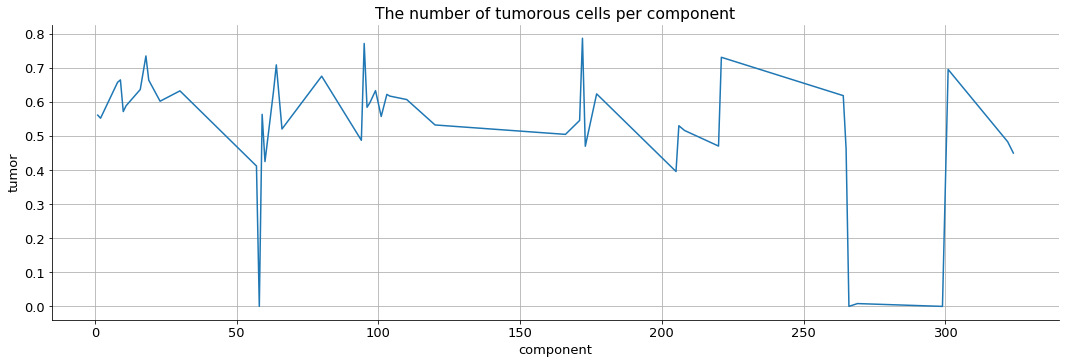

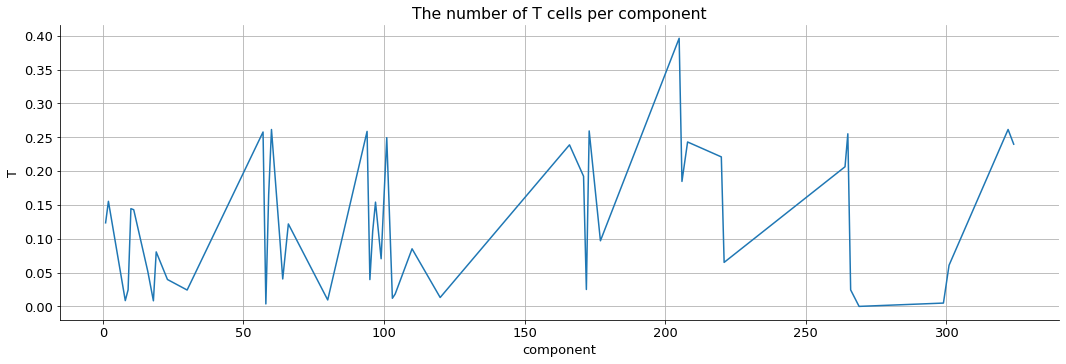

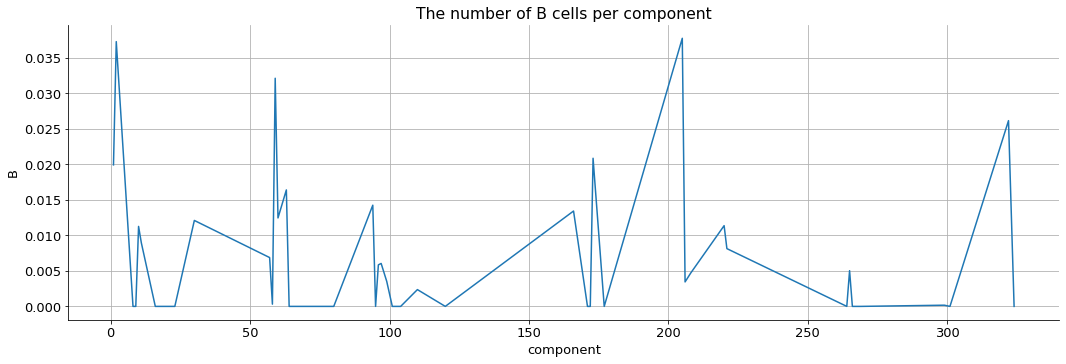

In [214]:
plot_relplot(phenotype_component_pivotted,'component','tumor',PLOT_PATH,'Reds','The number of tumorous cells per component',True)
plot_relplot(phenotype_component_pivotted,'component','T',PLOT_PATH,'Reds','The number of T cells per component',True)
plot_relplot(phenotype_component_pivotted,'component','B',PLOT_PATH,'Reds','The number of B cells per component',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','NK',PLOT_PATH,'Reds','The number of NK cells per component',True)


In [215]:
phenotype_component_pivotted = phenotype_component_pivotted.merge(size_df, on='component',how='left')

The cells that are not associated to a component are out of border cells which means that they interacts only with similar tissue type cells : ***Stroma-Stroma / Tumor-Tumor***

We can use this component as a baseline, and compare the density of T_Cells/ B_Cells in each component in the border.

We will consider two types of densities, density subject to the total number of cells and density subject to tumorous cells

In [216]:
phenotype_component_pivotted = phenotype_component_pivotted[phenotype_component_pivotted.tumor != 0 ].copy()

In [217]:
phenotype_component_pivotted = phenotype_component_pivotted.rename(columns = {'size_x':'size'})

In [218]:
main_phenotypes = ['T','B','NK','stroma','tumor','dendtritic','macrophages']
columns = phenotype_component_pivotted.columns
for pheno in main_phenotypes:
    if not(pheno in columns):
        phenotype_component_pivotted[pheno] = 0

In [219]:
phenotype_component_pivotted['T_tumor_density'] = phenotype_component_pivotted['T']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['B_tumor_density'] = phenotype_component_pivotted['B']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['NK_tumor_density'] = phenotype_component_pivotted['NK']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['stroma_tumor_density'] = phenotype_component_pivotted['stroma']/phenotype_component_pivotted['tumor']

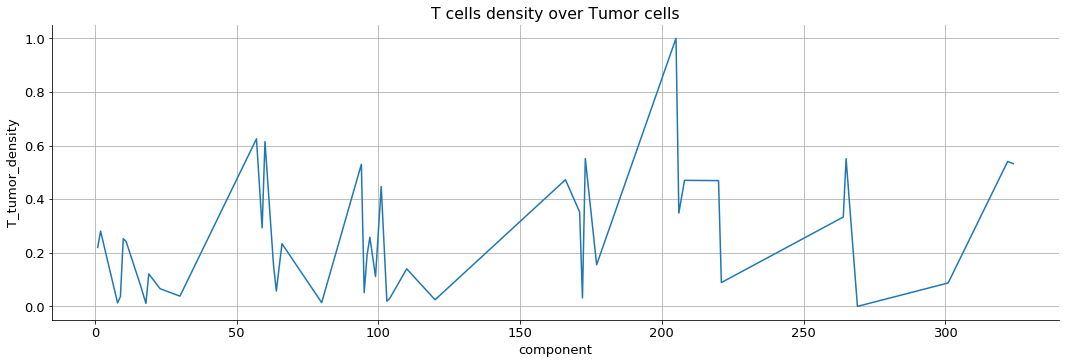

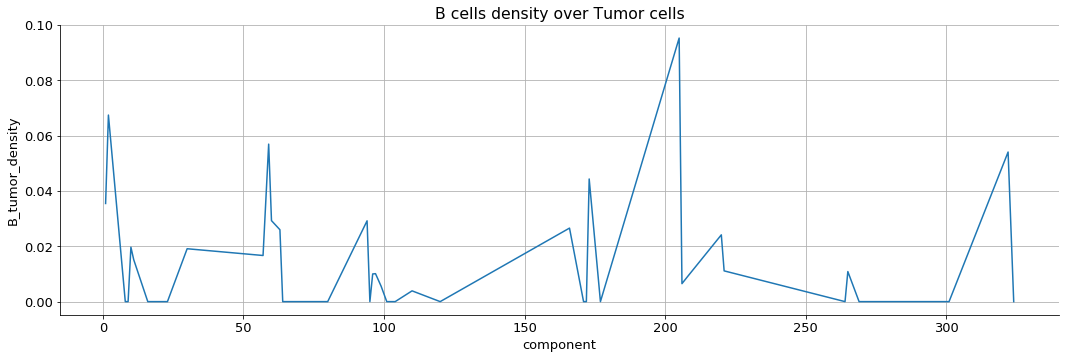

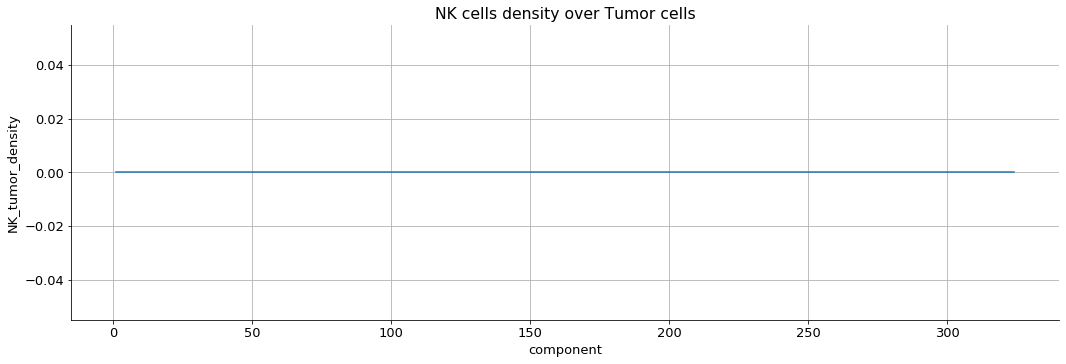

In [220]:
plot_relplot(phenotype_component_pivotted,'component','T_tumor_density',PLOT_PATH,'Reds','T cells density over Tumor cells',True)
plot_relplot(phenotype_component_pivotted,'component','B_tumor_density',PLOT_PATH,'Reds','B cells density over Tumor cells',True)
plot_relplot(phenotype_component_pivotted,'component','NK_tumor_density',PLOT_PATH,'Reds','NK cells density over Tumor cells',True)

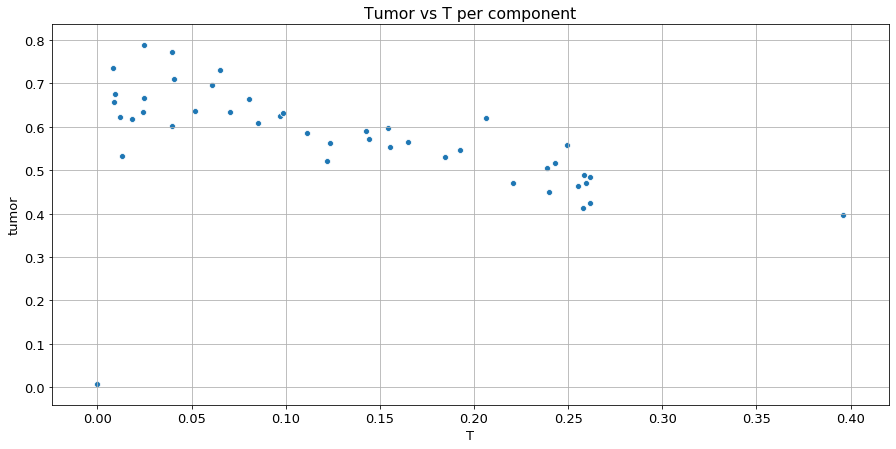

In [221]:
scatter_plot(phenotype_component_pivotted, 'T','tumor',PLOT_PATH,title ='Tumor vs T per component',savefig=False)

In [222]:
phenotype_component_pivotted.head(2)

,component,B,DP1,DP2,MISSING,T,dendtritic,macrophages,stroma,tumor,size,NK,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density
0,269,0.0,0.0,0.0,0.000000,0.000000,0.008264,0.057851,0.92562,0.008264,121,0,0.000000,0.0,0.0,112.000000
3,18,0.0,0.0,0.0,0.016529,0.008264,0.000000,0.016529,0.22314,0.735537,121,0,0.011236,0.0,0.0,0.303371


In [223]:
#plot_component(cell_graph,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#              remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#              savefig=SAVE_FIG, figname=FIG_NAME)

In [224]:
nodes = nodes.merge(phenotype_component_pivotted, on='component', how='left')

In [225]:
del phenotype_component_pivotted
del phenotype_component_grouped

# High level Graph 

In [226]:
nodes.head(3)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,stroma_degree,missing_degree,tumor_degree,total_degree,...,dendtritic,macrophages,stroma,tumor,size_y,NK,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density
0,414,15697.4,42869.0,stroma,T,True,0.0,0.0,1.0,1.0,...,0.000938,0.033302,0.231238,0.572233,2132.0,0.0,0.252459,0.019672,0.0,0.404098
1,415,15741.5,42870.4,stroma,stroma,True,3.0,0.0,0.0,3.0,...,0.000938,0.033302,0.231238,0.572233,2132.0,0.0,0.252459,0.019672,0.0,0.404098
2,417,15784.7,42873.4,stroma,B,True,1.0,0.0,0.0,1.0,...,0.000938,0.033302,0.231238,0.572233,2132.0,0.0,0.252459,0.019672,0.0,0.404098


## Aggregations

In [227]:
nodes.columns

Index(['cell_id', 'cell_x_position', 'cell_y_position', 'tissue_category',
       'phenotype', 'on_border', 'stroma_degree', 'missing_degree',
       'tumor_degree', 'total_degree', 'stroma_pheno_degree',
       'macrophages_degree', 'T_degree', 'MISSING_degree',
       'tumor_pheno_degree', 'B_degree', 'DP1_degree', 'DP2_degree',
       'dendtritic_degree', 'clustering_coef', 'component', 'size_x',
       'AUC_area', 'B-B', 'DP1-B', 'DP1-DP1', 'MISSING-B', 'MISSING-DP2',
       'MISSING-MISSING', 'T-B', 'T-DP1', 'T-DP2', 'T-MISSING', 'T-T',
       'dendtritic-B', 'dendtritic-DP2', 'dendtritic-MISSING', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-B', 'macrophages-DP1',
       'macrophages-DP2', 'macrophages-MISSING', 'macrophages-T',
       'macrophages-dendtritic', 'macrophages-macrophages', 'stroma-B',
       'stroma-DP1', 'stroma-DP2', 'stroma-MISSING', 'stroma-T',
       'stroma-dendtritic', 'stroma-macrophages', 'stroma-stroma', 'tumor-B',
       'tumor-DP1', 'tum

In [228]:
columns_to_avg = ['component','cell_x_position', 'cell_y_position', 'clustering_coef','missing_degree', 'stroma_degree', 'tumor_degree', 'total_degree',
       'B_degree', 'MISSING_degree', 'NK_degree', 'T_degree',
       'dendtritic_degree', 'macrophages_degree', 'tumor_pheno_degree', 'stroma_pheno_degree',
       'T','B', 'MISSING', 'NK', 'dendtritic', 'macrophages', 'stroma', 'tumor',
       'T_tumor_density', 'B_tumor_density', 'NK_tumor_density',
       'stroma_tumor_density','AUC_area','B-B',
       'MISSING-B', 'MISSING-MISSING', 'T-B', 'T-MISSING', 'T-T',
       'dendtritic-B', 'dendtritic-MISSING', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-B', 'macrophages-MISSING',
       'macrophages-T', 'macrophages-dendtritic', 'macrophages-macrophages',
       'stroma-B', 'stroma-MISSING', 'stroma-T', 'stroma-dendtritic',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-MISSING',
       'tumor-T', 'tumor-dendtritic', 'tumor-macrophages', 'tumor-stroma',
       'tumor-tumor']

all_columns = nodes.columns

In [229]:
#nodes = add_null_column(nodes,columns_to_sum)
nodes_to_components = add_null_column(nodes,columns_to_avg)

In [230]:
#component_nodes_sum = nodes[columns_to_sum].groupby(['component']).agg('sum').reset_index()
component_nodes = nodes_to_components.groupby(['component']).agg('mean').reset_index()
#component_nodes = component_nodes_sum.merge(component_nodes_avg, on='component', how ='left')
component_nodes = component_nodes.drop(['cell_id','on_border'],axis =1)

In [231]:
component_nodes.tail()

,component,cell_x_position,cell_y_position,stroma_degree,missing_degree,tumor_degree,total_degree,stroma_pheno_degree,macrophages_degree,T_degree,...,macrophages,stroma,tumor,size_y,NK,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density,NK_degree
42,269,17308.608264,43648.590083,10.611570,1.314050,0.107438,12.033058,10.793388,1.082645,0.000000,...,0.057851,0.925620,0.008264,121.0,0.0,0.000000,0.000000,0.0,112.000000,0.0
43,299,19419.164841,48500.492343,7.904665,4.696247,0.000000,12.600913,12.321501,0.074713,0.054260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
44,301,18649.441892,46852.663514,0.918919,0.000000,8.195946,9.114865,1.986486,0.290541,0.405405,...,0.027027,0.216216,0.695946,148.0,0.0,0.087379,0.000000,0.0,0.310680,0.0
45,322,18454.381373,50519.399346,2.179739,0.000000,6.160131,8.339869,1.205882,0.326797,1.627451,...,0.062092,0.166667,0.483660,306.0,0.0,0.540541,0.054054,0.0,0.344595,0.0
46,324,18173.032203,50738.295400,2.677966,0.000000,4.699758,7.377724,1.539952,0.254237,1.464891,...,0.036320,0.234867,0.450363,413.0,0.0,0.532258,0.000000,0.0,0.521505,0.0


In [232]:
component_x = component_nodes.cell_x_position.values
component_y = component_nodes.cell_y_position.values
points = []
for x,y in zip(component_x,component_y):
    points.append([x,y])

points = np.array(points)    
tri = Delaunay(points)

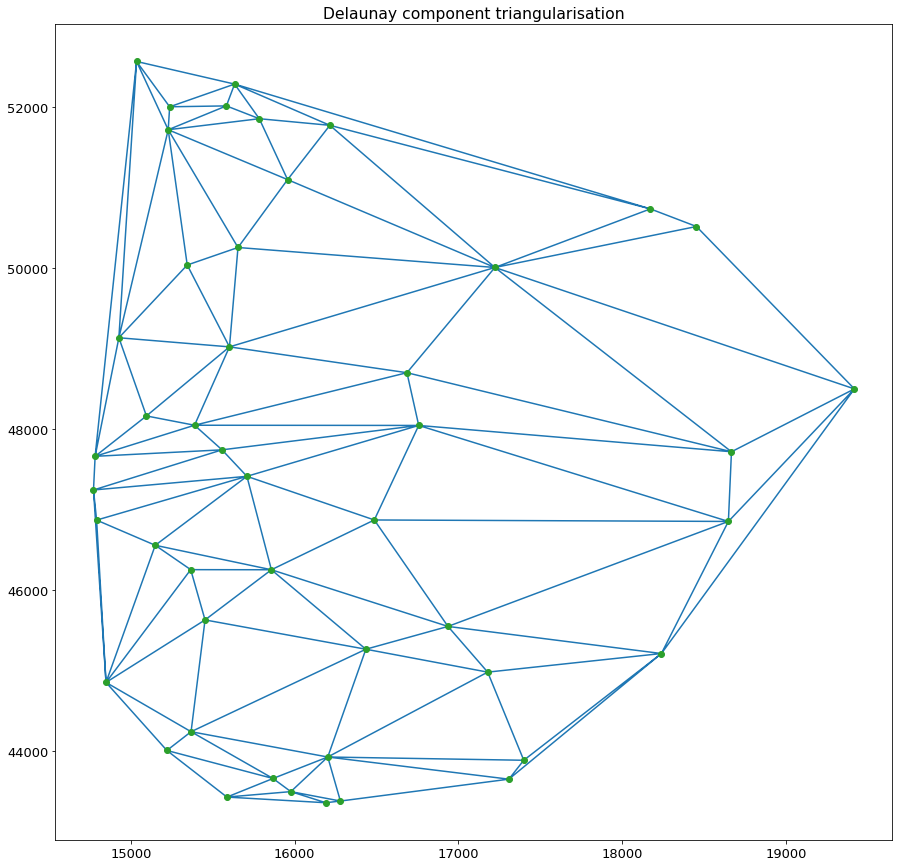

In [233]:
fig = plt.figure(figsize=(15,15))

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.title('Delaunay component triangularisation')    
plt.show()
fig.savefig(PLOT_PATH+'Delaunay_component_triangularisation no threshold.png')

## Compute threshold

In [234]:
coord = []
for i, row in component_nodes.iterrows():
    coord.append([row.cell_x_position, row.cell_y_position])
coord = np.array(coord)

tri = Delaunay(coord)
edges_0 = set()
dists = []
for tr in tri.vertices:
    for i in range(3):
        edge_idx0 = tr[i]
        edge_idx1 = tr[(i+1)%3]
        if (edge_idx1, edge_idx0) in edges_0:
            continue  # already visited this edge from other side
        p0 = coord[edge_idx0]
        p1 = coord[edge_idx1]
        dists.append(np.linalg.norm(p1 - p0))
        edges_0.add((edge_idx0, edge_idx1))

In [235]:
threshold = 2.5*np.median(dists)

In [236]:
vertices = component_nodes.component.values
coord, edges_component = get_high_level_graph(component_nodes,threshold)

The mean 1128.803421209471
The median 985.5984320527339


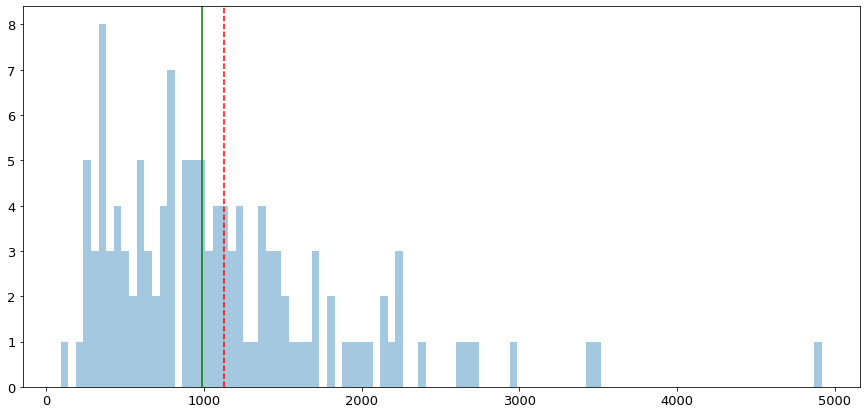

In [237]:
plt.figure(figsize=(15,7))
ax =sns.distplot(dists, hist=True, kde=False, bins=100)
print('The mean',np.mean(dists))
print('The median',np.median(dists))
ax.axvline(np.mean(dists), color='r', linestyle='--', label='mean')
ax.axvline(np.median(dists), color='g', linestyle='-', label='median')

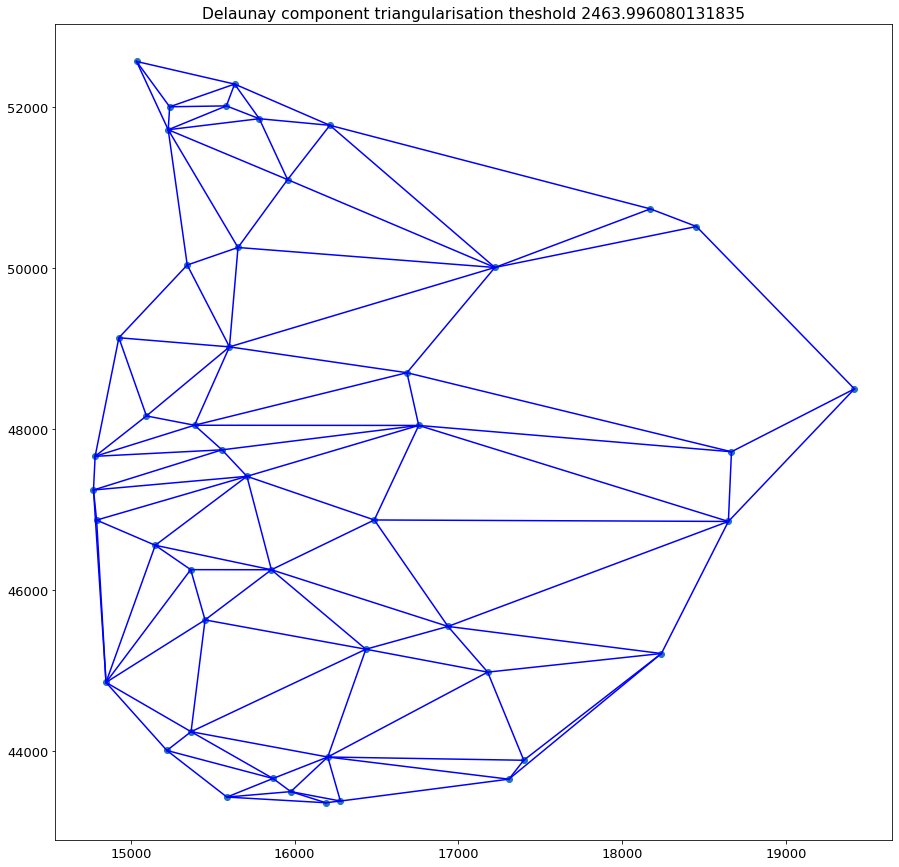

In [238]:
fig = plt.figure(figsize=(15,15))
plt.plot(coord[:, 0], coord[:, 1], 'o')
for i, j in edges_component:
    plt.plot(coord[[i, j], 0], coord[[i, j], 1], 'b')
    
plt.title('Delaunay component triangularisation theshold ' + str(threshold) )    
plt.show()
fig.savefig(PLOT_PATH+'Delaunay_component_triangularisation threshold :'+str(threshold)+'.png')    

### Build graph

In [239]:
component_graph = nx.Graph() # for a directed graph use nx.DiGraph()

component_graph.add_nodes_from(range(len(vertices)))  # add multiple nodes at once

component_graph.add_edges_from(edges_component)

#visualize_component_graph(component_graph,k=0.05, alpha=0.8,savefig=True,figname='High_level_graph_threshold_200.png')


In [240]:
laplacian_matrix = nx.laplacian_matrix(component_graph).A
eigen_vals, eigen_vects = np.linalg.eig(laplacian_matrix)

In [241]:
idx = (-eigen_vals).argsort()[::-1]   
eigenValues = eigen_vals[idx]
eigenVectors = eigen_vects[:,idx]

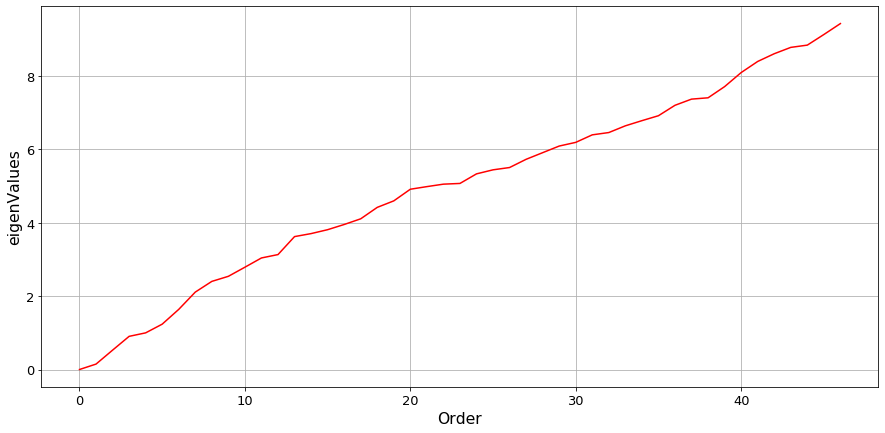

In [242]:
fig = plt.figure(figsize=(15,7))
plt.plot(eigenValues,color='r')
plt.grid()
plt.ylabel("eigenValues", size="large")
plt.xlabel("Order", size="large")

plt.title("", size="large")
plt.show();
fig.savefig(PLOT_PATH + 'T-Tumor edges count signal projection.png')

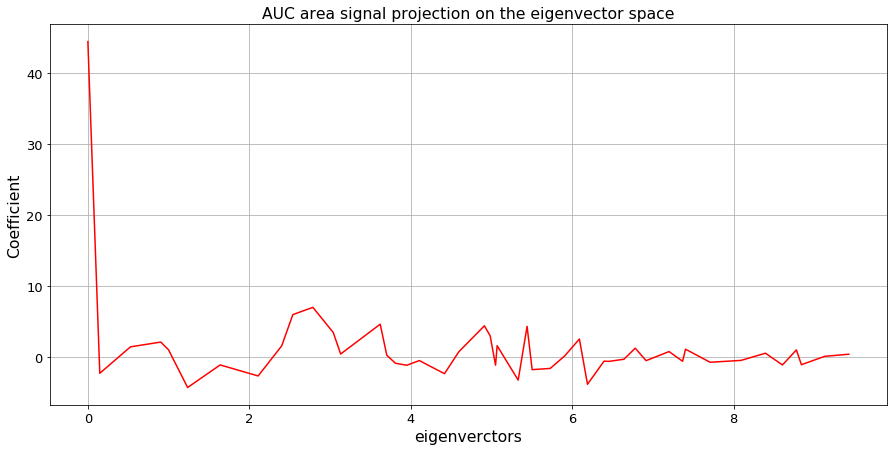

In [243]:
SIGNAL = np.array(component_nodes.AUC_area.fillna(0).values)
GRAPH = component_graph
FIGNAME = 'AUC area signal projection on the eigenvector space'
projection = project_signal(GRAPH,SIGNAL,PLOT_PATH,True,'b',True,FIGNAME)

## Quadratic laplacian forms

In [244]:
quadtratics = get_quadratic_laplacian_forms(component_nodes,vertices,edges_component)

In [245]:
quadtratics = pd.melt(quadtratics)

In [246]:
quadtratics.head()

,variable,value
0,cell_x_position,3.237193
1,cell_y_position,0.977053
2,stroma_degree,7.612356
3,missing_degree,4.605239
4,tumor_degree,6.839916


In [247]:
quadtratics_to_plot = quadtratics[quadtratics.variable.apply(lambda x : not(x in['cell_x_position','cell_y_position','T_density','B_density','NK_density','NK_degree','missing_degree','MISSING_degree','MISSING-B', 'MISSING-MISSING','T-MISSING','macrophages-MISSING','stroma-MISSING','tumor-MISSING','MISSING','dendtritic-MISSING','size_x','size_y']))]



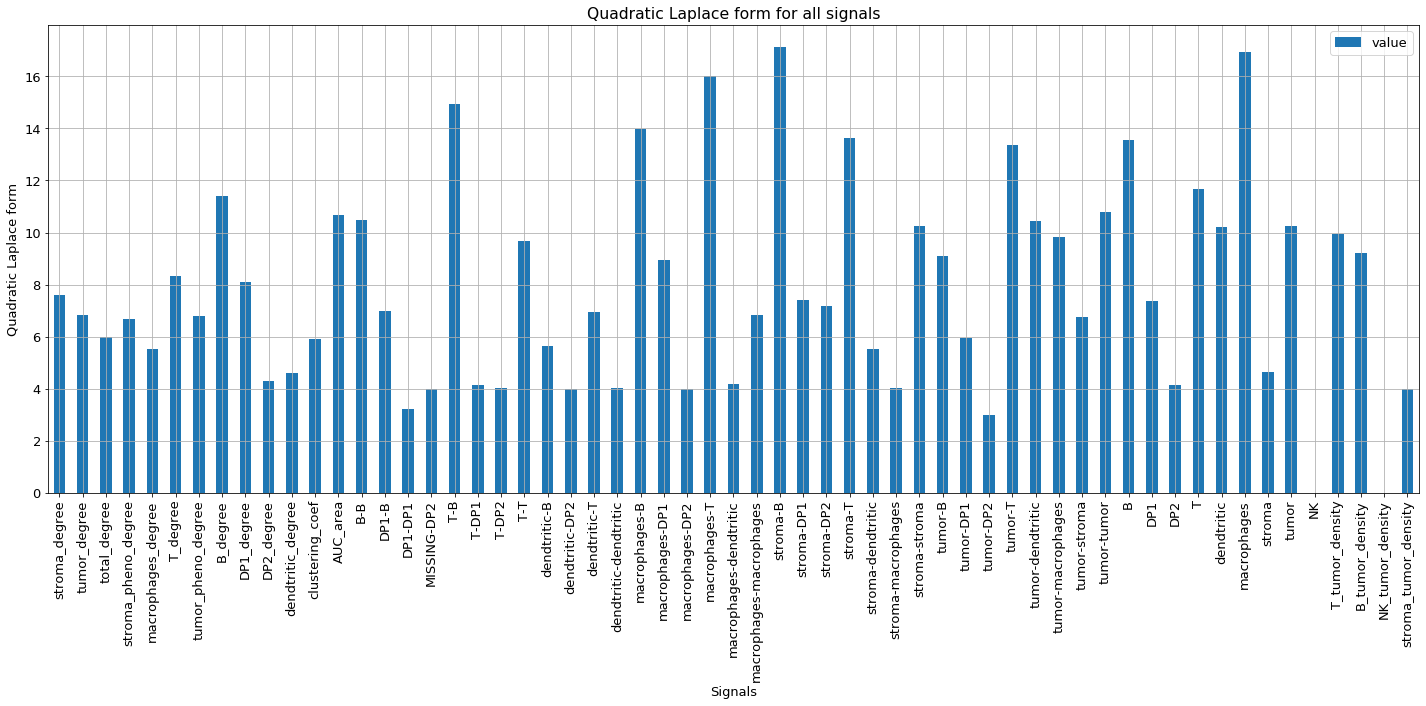

In [248]:
#fig = quadtratics_to_plot.sort_values(['value']).plot.bar(x='variable',y='value',rot=90,figsize =(20,10))
fig = quadtratics_to_plot.plot.bar(x='variable',y='value',rot=90,figsize =(20,10))

plt.xlabel('Signals')
plt.ylabel('Quadratic Laplace form')
plt.grid()
plt.title('Quadratic Laplace form for all signals')
plt.tight_layout()

plt.savefig(PLOT_PATH + 'Quadratic Laplace form for all signals.png')

In [249]:
nodes.to_csv(OUTPUT_PATH + 'nodes_features.csv', index = False)

In [250]:
component_nodes.to_csv(OUTPUT_PATH + 'component_features.csv', index = False)

In [251]:
get_quadratic_laplacian_forms(component_nodes,vertices,edges_component).to_csv(OUTPUT_PATH + 'laplace_quadratic_form_high_level_graph.csv', index = False)

In [252]:
nodes_stats.to_csv(OUTPUT_PATH + 'nodes_stats.csv', index = False)

In [253]:
len(edges)

272252

In [254]:
edges.component.unique()

array([  1,   2,   8,   9,  10,  11,  16,  18,  19,  23,  30,  57,  58,
        59,  60,  63,  64,  66,  80,  94,  95,  96,  97,  99, 101, 103,
       104, 110, 120, 166, 171, 172, 173, 177, 205, 206, 208, 220, 221,
       264, 265, 266, 269, 299, 301, 322, 324])